In [42]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

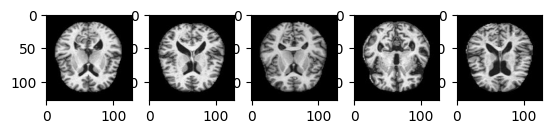

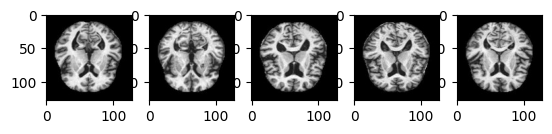

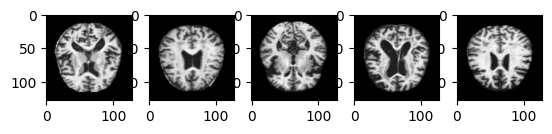

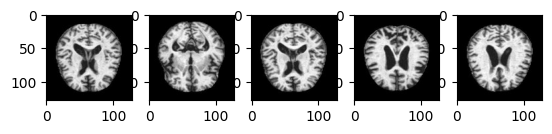

x train: (4160, 16384)
x validation: (520, 16384)
x test: (520, 16384)


In [43]:

# Loop through each file name


def load_dataset(image_dir, label):
    file_names = os.listdir(image_dir)

    images = []
    for file_name in file_names:
        file_path = os.path.join(image_dir, file_name)

        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            images.append(image)


    rows = 1
    cols = 5
    c = 1
    for i in range (0,5):
        plt.subplot(rows, cols, c)
        c+=1
        plt.imshow(images[i], plt.get_cmap('gray'))

    plt.show()

    images = np.array(images)
    images = images/255

    images = images.reshape(images.shape[0], -1)

    y_train = ( images.shape[0])*[ label ]
    y_train = np.array(y_train)

    return [images, y_train]


[x_train_0, y_train_0] = load_dataset("./Dataset1/Non_Demented", 0 )
[x_train_1, y_train_1] = load_dataset("./Dataset1/Very_Mild_Demented", 1)
[x_train_2, y_train_2] = load_dataset("./Dataset1/Mild_Demented", 2)
[x_train_3, y_train_3] = load_dataset("./Dataset1/Moderate_Demented", 3)

# print(x_train_0.shape, x_train_1.shape, x_train_2.shape, x_train_3.shape )

x_train_0 = x_train_0[:2000]
y_train_0 = y_train_0[:2000]

class_dict = {"Non_Demented": y_train_0.shape[0], "Very_Mild_Demented": y_train_1.shape[0], "Mild_Demented": y_train_2.shape[0], "Moderate_Demented": y_train_3.shape[0]}


X = np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3 ))
Y = np.concatenate((y_train_0, y_train_1, y_train_2, y_train_3 ))


indices = np.random.choice(X.shape[0], size = X.shape[0], replace = False)
X = X[indices]
Y = Y[indices]


# print(X.shape, Y.shape)

X_train = X[: int(X.shape[0] * 0.80)]
Y_train = Y[: int(X.shape[0] * 0.80)]

X_val = X[int(X.shape[0] * 0.80) : int(X.shape[0] * 0.90)]
Y_val = Y[int(Y.shape[0] * 0.80) : int(Y.shape[0] * 0.90)]

X_test = X[int(X.shape[0] * 0.90) : ]
Y_test = Y[int(X.shape[0] * 0.90) : ]

print(f"x train: {X_train.shape}")
print(f"x validation: {X_val.shape}")
print(f"x test: {X_test.shape}")




Text(0.5, 1.0, 'Distribution of Alzheimer MRI Images')

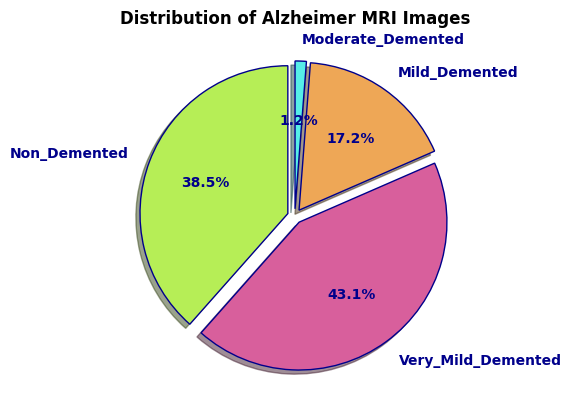

In [44]:
# pie chart for classes
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]
keys = list(class_dict.keys())
values = list(class_dict.values())
explode = (0.05,)*len(keys)

labels = [f'{key}' for key in keys]

plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 10, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
        {'edgecolor':'darkblue'} , labeldistance=1.15)
plt.title("Distribution of Alzheimer MRI Images", size=12, fontweight="bold")


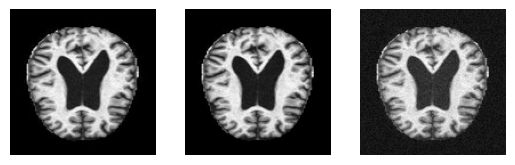

(10160, 16384)


In [45]:
# Applying Data augumentation on the train set

def apply_brightness(image, max_delta=50):
    delta = np.random.randint(-max_delta, max_delta)
    bright_image = np.clip(image.astype(np.int16) + delta, 0, 255).astype(np.uint8)
    return bright_image

def add_gaussian_noise(image, mean=0, stddev=5):
    noise = np.random.normal(mean, stddev, image.shape).astype(np.float64)  # Cast noise to np.uint8
    noisy_image = cv2.add(image, noise)
    return noisy_image

X_train_augmented = []
Y_train_augmented = []


for i in range(3000):
    image = X_train[i]
    y_image = Y_train[i]
    image= image.reshape((128, 128))
    image = image * 255


    X_train_augmented.append(image)
    Y_train_augmented.append(y_image)

    brightened_image = apply_brightness(image)
    X_train_augmented.append(brightened_image)
    Y_train_augmented.append(y_image)

    noisy_image = add_gaussian_noise(image)
    X_train_augmented.append(noisy_image)
    Y_train_augmented.append(y_image)

X_train_augmented = np.array(X_train_augmented)
Y_train_augmented = np.array(Y_train_augmented)


# printing the original image , brightened, image with added noise
rows = 1
cols = 3
for i in range(3):
    plt.subplot(rows, cols, i+1)
    plt.imshow(X_train_augmented[i], cmap='gray')
    plt.axis('off')
plt.show()

X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
X_train_augmented = X_train_augmented/255


X_train = np.concatenate([X_train_augmented , X_train[3000:]])
Y_train = np.concatenate([Y_train_augmented , Y_train[3000:]])



indices = np.random.choice(X_train.shape[0], size = X_train.shape[0], replace = False)
X_train = X_train[indices]
Y_train = Y_train[indices]
# print(X_train.shape)
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_train = X_train / 255

print(X_train.shape)




In [46]:
# graph of cummulative explained variance VS no of dimensions to be taken for PCA

# pca = PCA(n_components=6000)
# pca.fit(X_train)

# # Get explained variance ratio
# explained_variance_ratio = pca.explained_variance_ratio_

# # Calculate cumulative explained variance
# cumulative_variance = np.cumsum(explained_variance_ratio)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(cumulative_variance, marker='o', linestyle='-')
# plt.title('Cumulative Summation of Explained Variance')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid(True)
# plt.show()

In [47]:

#  PCA for the dataset
def calculate_pca(p):

    pca = PCA(n_components=p)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_val_pca = pca.transform(X_val)

    # applying QDA to find thhe accuracy corresponding to the dimensionality reduction

    # qda = QuadraticDiscriminantAnalysis()
    # qda.fit(X_train_pca, Y_train)

    # # Calculate the accuracy
    # accuracy = qda.score(X_test_pca, Y_test)
    # print("Accuracy after QDA on dimensionaly reduced dataset:", accuracy)
    return X_train_pca, X_test_pca, X_val_pca

#  taking PCA (p= 100), as it is the closest to the total accuracy without dimensional reduction


X_train , X_test, X_val= calculate_pca(500)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(10160, 500)
(520, 500)
(520, 500)


Validation Accuracy:  0.8096153846153846
Test accuracy:  0.8423076923076923
Accuracy of Non demented: 0.8341708542713567
Accuracy of Very Mild demented: 0.8181818181818182
Accuracy of Mild demented: 0.9052631578947369
Accuracy of Moderate demented: 1.0


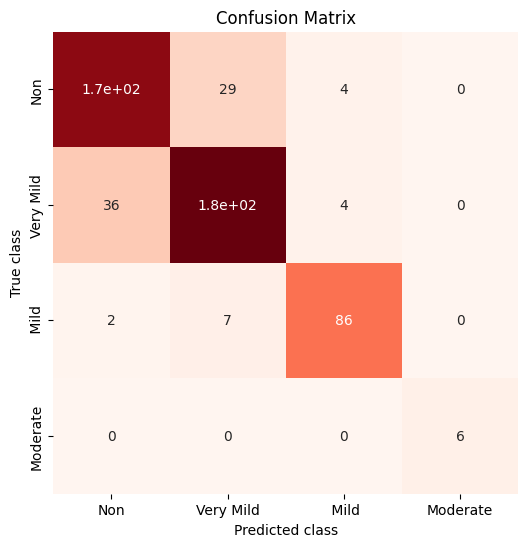

In [48]:
def find_class_accuracies(y_pred):
    classwise_correct_predicted_samples = [0] * 4
    classwise_total_samples = [0] * 4
    for i in range(Y_test.shape[0]):
        y = Y_test[i]
        classwise_total_samples[y]+=1
        if (y == y_pred[i]):
            classwise_correct_predicted_samples[y] +=1

    accuracies = [0] * 4
    for i in range(4):
        accuracies[i]= classwise_correct_predicted_samples[i] / classwise_total_samples[i]


    print(f"Accuracy of Non demented: {accuracies[0]}")
    print(f"Accuracy of Very Mild demented: {accuracies[1]}")
    print(f"Accuracy of Mild demented: {accuracies[2]}")
    print(f"Accuracy of Moderate demented: {accuracies[3]}")


# Model1: Multiclass Logistic Regression (Accuracy  = 67.3% )
log_reg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', max_iter=2000)
log_reg.fit(X_train, Y_train)

validation_accuracy = log_reg.score(X_val, Y_val)
print("Validation Accuracy: ", validation_accuracy)

test_accuracy = log_reg.score(X_test, Y_test)
print("Test accuracy: ", test_accuracy)
y_pred = log_reg.predict(X_test)
find_class_accuracies(y_pred)



# for the test set calculaitng the recall = no of true positives / total no of positives = no of true positives / no of true positives + no of false negatives

conf_matrix = confusion_matrix(Y_test, y_pred)

classes =['Non', 'Very Mild', ' Mild', 'Moderate' ]
plt.figure(figsize = (6,6), facecolor=(1,1,1,0))
sns.heatmap(conf_matrix, annot=True, cmap = 'Reds', cbar = False,xticklabels=classes , yticklabels=classes)

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion Matrix")
plt.show()



In [50]:
# decision tree model - used cross validation to get the max depth to be choosen - (Accuracy = 73.125 %)

param_grid = {'max_depth': [25, 50 , 100]}
decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')  # cross validation
grid_search.fit(X_train, Y_train)

best_depth = grid_search.best_params_['max_depth']
print(best_depth)

best_decision_tree = grid_search.best_estimator_

validation_accuracy = best_decision_tree.score(X_val, Y_val)
print("Validation Accuracy: ", validation_accuracy)

test_accuracy = best_decision_tree.score(X_test, Y_test)
print("Test accuracy: ", test_accuracy)
y_pred = best_decision_tree.predict(X_test)
find_class_accuracies(y_pred)



50
Validation Accuracy:  0.6923076923076923
Test accuracy:  0.676923076923077
Accuracy of Non demented: 0.6532663316582915
Accuracy of Very Mild demented: 0.7136363636363636
Accuracy of Mild demented: 0.6526315789473685
Accuracy of Moderate demented: 0.5


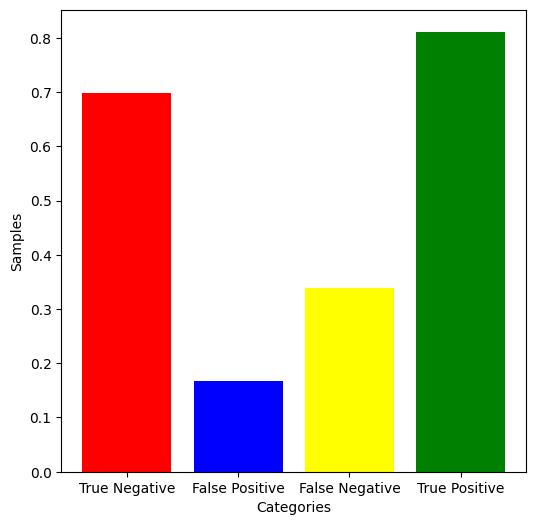

In [41]:
Y_pred = decision_tree.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)

total_negative = np.sum(conf_matrix[0])
total_positive = Y_test.shape[0] - total_negative
tn = conf_matrix[0][0] / total_negative
fn = (conf_matrix[1][0] + conf_matrix[2][0] + conf_matrix[3][0]) / total_negative
fp = (conf_matrix[0][1] + conf_matrix[0][2] + conf_matrix[0][3]) / total_positive
tp = 0

for i in range(1,4):
    for j in range(1,4):
        tp += conf_matrix[i][j]
tp = tp / total_positive

plt.figure(figsize=(6,6))
categories = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = [tn, fp, fn, tp]


plt.bar(categories ,counts, color = ['Red', 'Blue', 'Yellow', 'Green'])
plt.xlabel('Categories')
plt.ylabel('Samples')
plt.show()

In [40]:
# random forest
X_combined = np.concatenate((X_train, X_val))
Y_combined = np.concatenate((Y_train, Y_val))

random_forest = RandomForestClassifier(n_estimators = 75)
random_forest.fit(X_combined, Y_combined)

test_accuracy = random_forest.score(X_test, Y_test)
print("Test Accuracy: ", test_accuracy)
y_pred = random_forest.predict(X_test)
find_class_accuracies(y_pred)



Test Accuracy:  0.9673076923076923
Accuracy of Non demented: 0.978494623655914
Accuracy of Very Mild demented: 0.995475113122172
Accuracy of Mild demented: 0.9056603773584906
Accuracy of Moderate demented: 0.7142857142857143


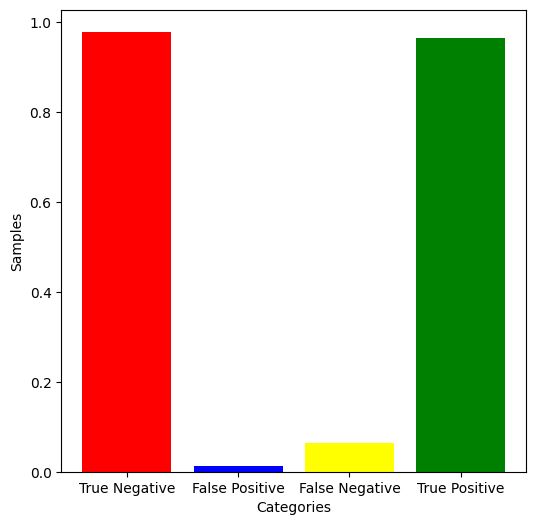

In [38]:
# considering very-mild, mild and moderate to be positive and non-demented to be negative
Y_pred = random_forest.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)

total_negative = np.sum(conf_matrix[0])
total_positive = Y_test.shape[0] - total_negative
tn = conf_matrix[0][0] / total_negative
fn = (conf_matrix[1][0] + conf_matrix[2][0] + conf_matrix[3][0]) / total_negative
fp = (conf_matrix[0][1] + conf_matrix[0][2] + conf_matrix[0][3]) / total_positive
tp = 0

for i in range(1,4):
    for j in range(1,4):
        tp += conf_matrix[i][j]
tp = tp / total_positive

plt.figure(figsize=(6,6))
categories = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = [tn, fp, fn, tp]

plt.bar(categories ,counts, color = ['Red', 'Blue', 'Yellow', 'Green'])
plt.xlabel('Categories')
plt.ylabel('Samples')
plt.show()

